# **Towards Wake Word Detection - A Two Word Classifier**

Author: Philipp Weidel

Wake word detection is the task to detect one specific word in a stream of contiuous speech or noise. Wake word detection has been solved in a satisfactory fashion by Google, Amazon etc. Nowadays, the challange in this task is to solve it consuming less energy and with less delay than state-of-the art solutions.

Spiking neural networks have the capability to react much faster than their rate-based counterparts while burning much less energy. This tutorial shows a simplified task towards wake word detection using a spiking neural network in which a classifier is trained to distinguish two words. 


In [1]:
import importlib
import sys
# - Disable warning display
import warnings
warnings.filterwarnings('ignore')
import os
from IPython.display import Javascript, Audio, SVG
import librosa
import librosa.display as rdp
from tqdm import tqdm
import pylab as plt
import numpy as np
if importlib.util.find_spec('soundfile') is None:
  !pip install soundfile
import soundfile

# install NEST
if importlib.util.find_spec('nest') is None:
  !wget https://github.com/nest/nest-simulator/archive/v2.18.0.tar.gz
  !tar xf v2.18.0.tar.gz
  %cd nest-simulator-2.18.0/
  !mkdir build && mkdir install
  %cd build
  !cmake .. -DCMAKE_INSTALL_PREFIX:PATH=../install -Dwith-python=3
  !make -j 8 && make install -j 8
  %cd ../..
  sys.path.append('/content/nest-simulator-2.18.0/install/lib/python3.6/site-packages')
import nest

# install rockpool
if importlib.util.find_spec('rockpool') is None:
  !pip install rockpool

# download data
if not os.path.exists("audio_data.tar"):
  !wget https://www.dropbox.com/s/oclm9ahsalbd16s/audio_data.tar
  !wget https://www.dropbox.com/s/ewqeun7f8orxm9o/network.svg
  !tar xf audio_data.tar

# **Data inspection**

First, let's inspect the data at hand.

We specify the location of the data in *DATA_PATH* and load an example for each of the keywords **yes** and **no**.


In [2]:
DATA_PATH = "audio_data/"

sample_yes = "fac7deca_nohash_0.wav"
sample_no = "e649aa92_nohash_0.wav"

example_audio_yes = DATA_PATH + f"audio/yes/{sample_yes}.wav"
example_audio_no = DATA_PATH + f"audio/no/{sample_no}.wav"

example_yes, sr = librosa.load(example_audio_yes)
example_no, sr = librosa.load(example_audio_no)

In [3]:
Audio(example_audio_yes)

In [4]:
Audio(example_audio_no)

## **Visualization**

Now let's visualize the data. We can of course visualize the data as a one dimensional signal of sound-pressure in time-domain.

We finde that the samples are each one second long and have a sampling rate of 16kHz. Also, each sample is normalized such that the maximum absolute value is $1$.

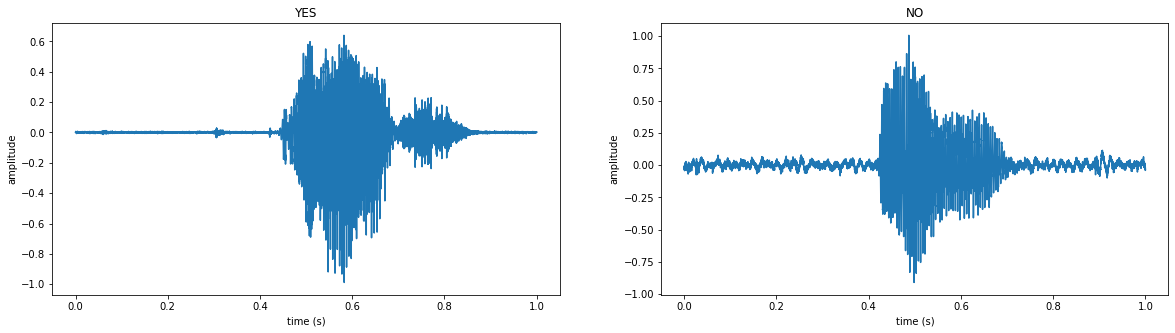

In [5]:
t_example = np.arange(0, len(example_yes) / sr, 1 / sr)

fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(121)
ax0.set_title("YES")
ax0.set_xlabel("time (s)")
ax0.set_ylabel("amplitude")
ax0.plot(t_example, example_yes)

ax1 = fig.add_subplot(122)
ax1.set_title("NO")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("amplitude")
ax1.plot(t_example, example_no)

### **Frequency domain**

Audio is better described in frequency domain. So let's see how these two samples compare after transformation using short time fourier transformation (STFT).

As the sampling rate is 16kHz, we can see frequency components up to 8kHz (nyquist frequency). The keyword **yes** contains much more high frequency components than **no**.

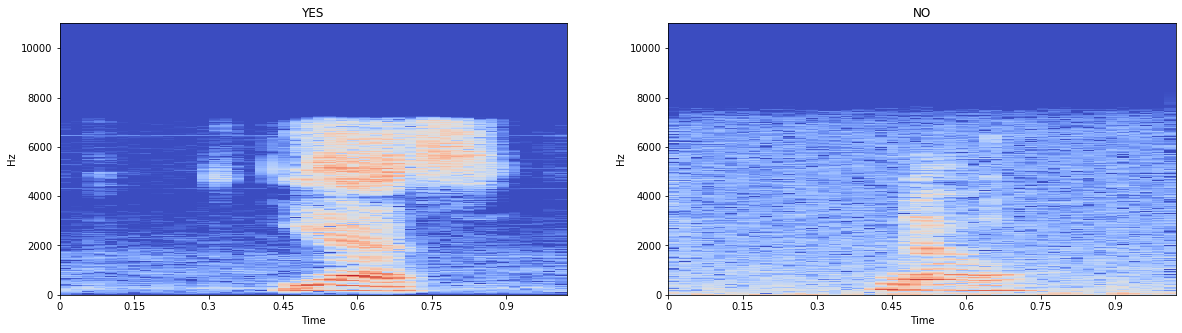

In [6]:
stft_yes = librosa.stft(example_yes)
stft_no = librosa.stft(example_no)

fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(121)
ax0.set_title("YES")
rdp.specshow(librosa.amplitude_to_db(stft_yes), sr=sr, x_axis='time', y_axis='hz')

ax1 = fig.add_subplot(122)
ax1.set_title("NO")
rdp.specshow(librosa.amplitude_to_db(stft_no), sr=sr, x_axis='time', y_axis='hz')


### **Time continuous filter**

In order to compute the STFT we have to bin the data into at least 10 ms time bins which contradicts our goal to get a low-latency solution. Also it is difficult to build an STFT in asynchronous neuromorphic hardware. 

For low-energy and low-latency solutions with very similar results, we can use time-continuous filters such as Butterworh band-pass filters. The butterworth filter removes frequncies in the original data which are outside two cutoff frequncies. Hence, we obtain the power over time in specific frequency bands.

We provide pre-filtered data using 32 2nd order Butterworth band-pass filters linearly distributed in [Mel](https://en.wikipedia.org/wiki/Mel_scale) scale.

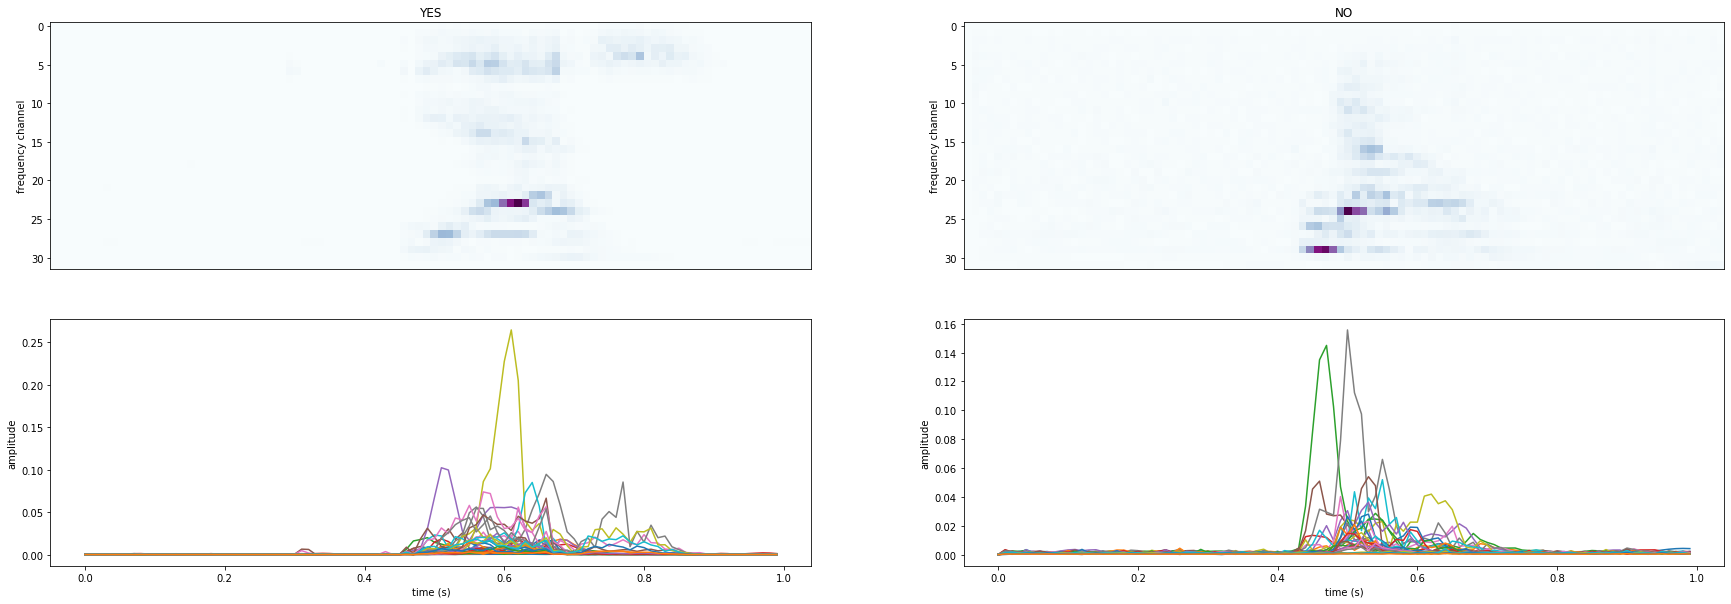

In [7]:
example_preprocessed_yes = DATA_PATH + f"cache/yes/{sample_yes}_filtered.npz"
example_preprocessed_no = DATA_PATH + f"cache/no/{sample_no}_filtered.npz"

preprocessed_yes = np.load(example_preprocessed_yes, allow_pickle=True)
preprocessed_no = np.load(example_preprocessed_no, allow_pickle=True)

len_samples = 100
preprocessed_sr = 100.
num_channels = 32
num_labels = 2

t_preprocessed = np.arange(0, len(preprocessed_yes) / preprocessed_sr, 1 / preprocessed_sr)

fig = plt.figure(figsize=(30, 10))

ax0 = fig.add_subplot(221)
ax0.set_title("YES")
ax0.set_ylabel("frequency channel")
ax0.set_xticks([])
plt.imshow(preprocessed_yes[:, ::-1].T, aspect='auto', cmap='BuPu')

ax1 = fig.add_subplot(222)
ax1.set_title("NO")
ax1.set_ylabel("frequency channel")
ax1.set_xticks([])
plt.imshow(preprocessed_no[:, ::-1].T, aspect='auto', cmap='BuPu')

ax2 = fig.add_subplot(223)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("amplitude")
ax2.plot(t_preprocessed, preprocessed_yes)

ax3 = fig.add_subplot(224)
ax3.set_xlabel("time (s)")
ax3.set_ylabel("amplitude")
ax3.plot(t_preprocessed, preprocessed_no)


print("")

# **Training**

## **Load more data**

Now we have to load more data to train a model.

Here you can specify the number of samples to use and also which keywords to use.
Available keywords are **yes**, **no**, **left**, **right** and **on**.



In [8]:
from glob2 import glob

percentage = 1.0 # how much data to use

keywords = ['yes', 'no'] # options: left, right, on, yes, no
ratio_train = 0.8

# get all files using these keywords and randomize order
fns = []
for keyword in keywords:
    fns += glob(DATA_PATH + f"cache/**/{keyword}/**/*filtered.npz")
np.random.shuffle(fns)

# create sub-sets for training and test data
num_train_samples = int(len(fns) * ratio_train * percentage)
num_test_samples = int(len(fns) * (1 - ratio_train) * percentage)

data = []
targets = []
for fn in fns:
    # load filtered data
    data.append(np.load(fn, allow_pickle=True))
    
    # create target label based on filename
    label_id = np.array(["cache/" + k in fn for k in keywords], dtype=int)    
    target = np.ones([len(data[-1]), num_labels]) * label_id
    targets.append(target)

train_data = data[:num_train_samples]
train_targets = targets[:num_train_samples]

test_data = data[num_train_samples:num_train_samples+num_test_samples]
test_targets = targets[num_train_samples:num_train_samples+num_test_samples]


    

## **Linear regression**

To get a baseline how easy this task is, we use simple linear regression.

We first flatten the data to have one big chunk of data, then we use Ridge regression from scikit-learn for classification. 

Afterwards we visualize the first 10 seconds. You can try different values for the regularization term *alpha*.

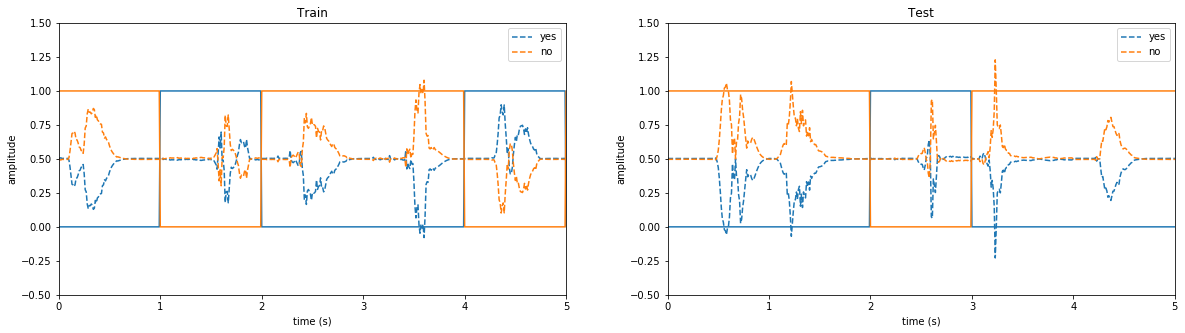

In [9]:
from sklearn.linear_model import Ridge

# flatten data
train_data_flat = np.reshape(train_data, [-1, num_channels])
train_targets_flat = np.reshape(train_targets, [-1, num_labels])

test_data_flat = np.reshape(test_data, [-1, num_channels])
test_targets_flat = np.reshape(test_targets, [-1, num_labels])

# train linear model
clf = Ridge(alpha=0.01)
clf.fit(train_data_flat, train_targets_flat)

# predict train and test data
train_pred = clf.predict(train_data_flat)
test_pred = clf.predict(test_data_flat)

# visualize the first seconds

train_time = np.arange(0, len(train_data_flat) / preprocessed_sr, 1 / preprocessed_sr)
test_time = np.arange(0, len(test_data_flat) / preprocessed_sr, 1 / preprocessed_sr)

fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(121)
ax0.set_title("Train")
ax0.set_xlabel("time (s)")
ax0.set_ylabel("amplitude")
ax0.set_xlim([0, 5])
ax0.set_ylim([-.5, 1.5])
ax0.plot(train_time, train_pred, '--')
plt.gca().set_prop_cycle(None)
ax0.plot(train_time, train_targets_flat)
ax0.legend(keywords)

ax1 = fig.add_subplot(122)
ax1.set_title("Test")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("amplitude")
ax1.set_xlim([0, 5])
ax1.set_ylim([-0.5, 1.5])
ax1.plot(test_time, test_pred, '--')
plt.gca().set_prop_cycle(None)
ax1.plot(test_time, test_targets_flat)
ax1.legend(keywords)



### **Testing**

In order to obtain an accuracy score for the linear model, we predict each sample individually and sum up the prediction. The most active output channel is the predicted target.

For the keywords **yes** vs **no** and using the complete dataset, the accuracy should settle around 89%.


950it [00:00, 16690.78it/s]



test accuracy 0.8652631578947368
[[384  90]
 [ 38 438]]


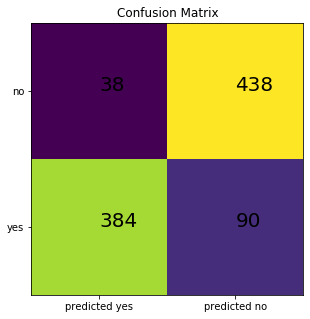

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix

true_labels = []
pred_labels = []

for i, d in tqdm(enumerate(test_data)):
    pred = clf.predict(d)
    pred_label = np.argmax(np.sum(pred, axis=0))
    true_label = np.argmax(np.sum(test_targets[i], axis=0))
    
    true_labels.append(true_label)
    pred_labels.append(pred_label)    

rr_acc = accuracy_score(true_labels, pred_labels)
rr_cm = confusion_matrix(true_labels, pred_labels)

print(f"\n\ntest accuracy {rr_acc}")

plt.figure(figsize=(20, 5))
plt.imshow(rr_cm)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.title("Confusion Matrix")
plt.xticks([0, 1], ["predicted " + k for k in keywords])
plt.yticks([0, 1], keywords)
for i, _ in enumerate(rr_cm):
    for j, _ in enumerate(rr_cm[i]):
        plt.text(j, i, rr_cm[i, j], fontsize=20)        

# **Rockpool**

## **Dataformat**

Before getting into the spiking neural network models, let's bring the data into a format which is understood by Rockpool.

In Rockpool there are two different kinds of Timeseries classes, TSContinuous and TSEvent. 
TSContinuous is used for time-continuous data such as the filtered audio samples in this task. The TSEvent class is used for spiking data which is used in spiking layers.

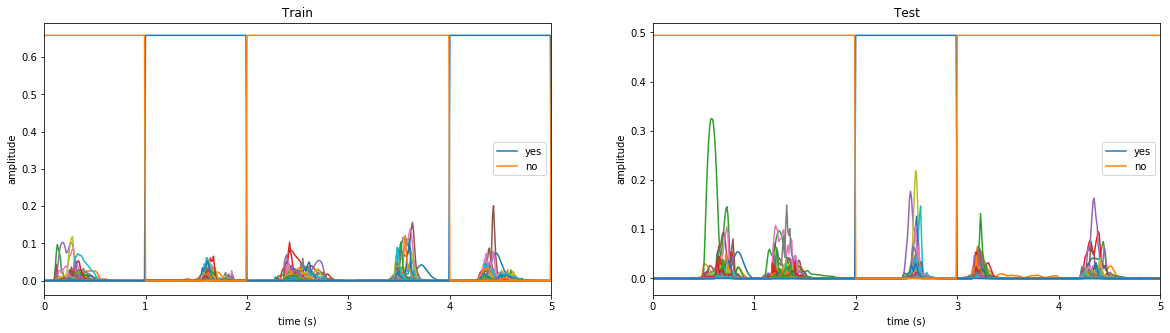

In [11]:
from rockpool.timeseries import TSContinuous, TSEvent

ts_train = TSContinuous(train_time, train_data_flat) 
ts_test = TSContinuous(test_time, test_data_flat) 

fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(121)
ax0.set_title("Train")
ax0.set_xlabel("time (s)")
ax0.set_ylabel("amplitude")
ax0.set_xlim([0, 5])
ts_train.plot()
plt.gca().set_prop_cycle(None)
ax0.plot(train_time, train_targets_flat * np.max(ts_train.samples))
ax0.legend(keywords)


ax1 = fig.add_subplot(122)
ax1.set_title("Test")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("amplitude")
ax1.set_xlim([0, 5])
ts_test.plot()
plt.gca().set_prop_cycle(None)
ax1.plot(test_time, test_targets_flat * np.max(ts_test.samples))
ax1.legend(keywords)



## **Reservoir computing**


Now let's get into a spiking neural network model.
In this case we want to train a reservoir computer (aka Liquid State Machine) to solve the task. We choose this model for several reasons:

1) Dimensionality expansion. The data is expanded to a larger dimensionality which should make it easier to find a linear separatrix between the two different classes.

2) Temporal integration. Using recurrent connections and the inherent temporal dynamics of Integrate-And-Fire neurons, the network has a certain amount of memory which allows to integrate the input over time.

3) Low power. The activity in the reservoir can be very sparse and therefore lead to low power consumption.

The LSM contains of three stages:

First, we have to convert the time-continuous data to spikes. Here we use rate-coding, meaning the higher the power in a certain frequency, the more spikes are emitted.

Second, we have to project the input spikes to a recurrently connected reservoir of IAF neurons. The most important parameters for the reservoir are the number of neurons, the synaptic and membrane time constants, the sparsity and distribution of weights.

Third, the output layer has access to all reservoir neurons and uses the low-pass filtered (exponential) spike train to train a linear regressor (ridge regression).

<img src="https://drive.google.com/uc?export=view&id=15PWoQV3bANlLh10eRkEfOb8-clEQ_vpw" width="800">


Let's define these parameters.

In [12]:
# parameters
dt = 0.001 # sec

# spike conversion
weights_spike_conv = 3.0
tau_mem_inp = 0.01 #sec

# reservoir
num_neurons = 100
sparsity_inp = 0.5 # percent
sparsity_res = 0.1 # percent
bias = 0.0

w_inp = np.random.normal(loc=0.0, scale=0.01, size=num_channels * num_neurons)
w_inp[np.random.choice(range(len(w_inp)), size=int(len(w_inp) * (1 - sparsity_inp)))] = 0
w_inp = w_inp.reshape(num_channels, num_neurons)

w_rec = np.random.normal(loc=-0.0001, scale=0.0002, size=num_neurons * num_neurons)
w_rec[np.random.choice(range(len(w_inp)), size=int(len(w_inp) * (1 - sparsity_res)))] = 0
w_rec = w_rec.reshape(num_neurons, num_neurons)

tau_mem = tau_syn = 0.05

# output
tau_syn_out = 0.1


Now we can create the model using the parameters we just defined.


For the spike conversion, we use a feed-forward Integrate-And-Fire (**FFIAF**) layer, for the reservoir a recurrent Integrate-And-Fire layer with spiking input (**RecIAFSpkIn**) and the readout layer is a feed-forward exponential filter (**FFExpSyn**).

Here we use NEST as a backend the first two layers, so we add a **NEST** to the layer name but there are also other backends you could use.


In [13]:
from rockpool.layers import FFIAFNest, RecIAFSpkInNest, FFExpSyn
from rockpool import Network

# spike conversion
lyr_inp = FFIAFNest(weights=np.eye(num_channels) * weights_spike_conv,
                    tau_mem=tau_mem_inp,
                    bias=0.,
                    dt=dt,
                    name='input')

# reservoir
lyr_res = RecIAFSpkInNest(weights_in=w_inp,
                          weights_rec=w_rec,
                          bias=bias,
                          tau_mem=tau_mem,
                          tau_syn_exc=tau_syn,
                          tau_syn_inh=tau_syn,
                          dt=dt,
                          num_cores=1,
                          name='reservoir')

# linear readout
lyr_out = FFExpSyn(weights=np.zeros([num_neurons, num_labels]),
                   tau_syn=tau_syn_out,
                   dt=dt,
                   name="output")

net = Network(lyr_inp, lyr_res, lyr_out)


Now we can visualize the activity of the network.

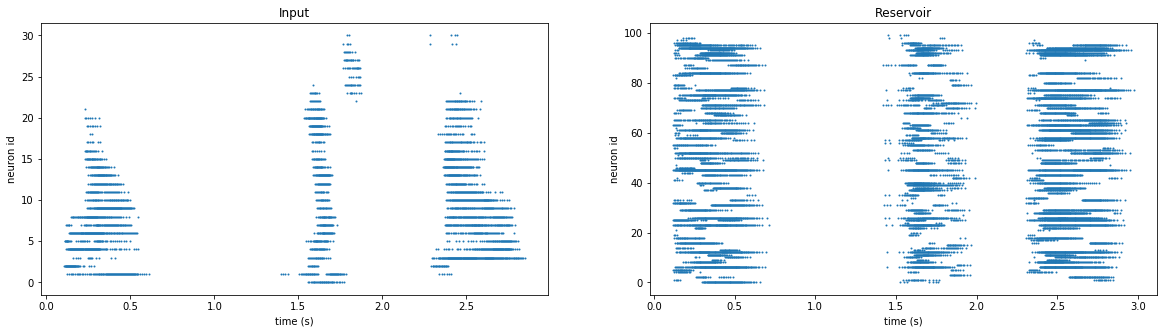

In [14]:
net.reset_all()

act = net.evolve(ts_train, duration=3., verbose=False)

fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(121)
ax0.set_title("Input")
ax0.set_xlabel("time (s)")
ax0.set_ylabel("neuron id")
act['input'].plot(s=1)

ax1 = fig.add_subplot(122)
ax1.set_title("Reservoir")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("neuron id")
act['reservoir'].plot(s=1)


## **Training**

Let's train the model on each single training sample.

In [15]:
time_single_sample = np.arange(0, len_samples / preprocessed_sr, 1 / preprocessed_sr)

true_labels = []
pred_labels = []
for i, d in tqdm(enumerate(train_data)):
    net.reset_all()
    
    ts_inp = TSContinuous(time_single_sample, d)
    ts_tgt = TSContinuous(time_single_sample, train_targets[i])

    act = net.evolve(ts_inp, verbose=False)
    
    net.output.train_rr(ts_tgt,
                        ts_input=act['reservoir'],
                        regularize=0.001,
                        train_biases=True,
                        is_first=i == 0,
                        is_last=i == len(train_data)-1)
                     
    

1558it [01:20, 20.87it/s]

Layer `output`: No input spikes for training.


3800it [03:18, 19.15it/s]


950it [00:34, 27.84it/s]




test accuracy 0.9221052631578948


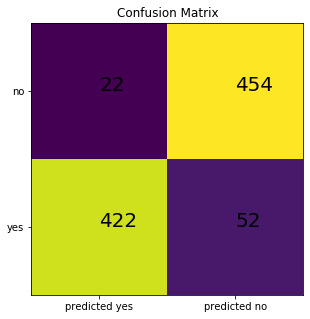

In [16]:
true_labels = []
pred_labels = []

for i, d in tqdm(enumerate(test_data)):
    net.reset_all()
    
    ts_inp = TSContinuous(time_single_sample, d)
  
    act = net.evolve(ts_inp, verbose=False)
    pred = act['output'].samples
    
    pred_label = np.argmax(np.sum(pred, axis=0))
    true_label = np.argmax(np.sum(test_targets[i], axis=0))
    
    pred_labels.append(pred_label)
    true_labels.append(true_label)
    
acc = accuracy_score(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)

print(f"\n\ntest accuracy {acc}")

plt.figure(figsize=(20, 5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.xticks([0, 1], ["predicted " + k for k in keywords])
plt.yticks([0, 1], keywords)
for i, _ in enumerate(cm):
    for j, _ in enumerate(cm[i]):
        plt.text(j, i, cm[i, j], fontsize=20)


## **Live demo**

Before testing the model in a live setup, make sure to train it on a large portion of the data.

You can use the following code to record some audio using your microphone.

In [51]:
global microphone
microphone = None

def record(sec=1):
    if not importlib.util.find_spec('google.colab') is None:


        RECORD = """
        const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader()
          reader.onloadend = e => resolve(e.srcElement.result)
          reader.readAsDataURL(blob)
        })

        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({ audio: true })
          recorder = new MediaRecorder(stream)
          chunks = []
          recorder.ondataavailable = e => chunks.push(e.data)
          recorder.start()
          await sleep(time)
          recorder.onstop = async ()=>{
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
          }
          recorder.stop()
        })
        """
        
        # run on colab
        from google.colab import output
        from base64 import b64decode
        from io import BytesIO
        if importlib.util.find_spec('pydub') is None:
            !pip install pydub
        if importlib.util.find_spec('pydub') is None:
            sys.path.append("/usr/local/lib/python3.8/site-packages")
        from pydub import AudioSegment
        
        display(Javascript(RECORD))
        s = output.eval_js('record(%d)' % (sec * 1000))
        b = b64decode(s.split(',')[1])
        audio = AudioSegment.from_file(BytesIO(b))
        fr = audio.frame_rate
        audio = np.array(audio.get_array_of_samples()) / audio.max_possible_amplitude
        audio = librosa.resample(audio, fr, 16000)
        return audio, 16000
    
    else:
        # run local
        import sounddevice as sd
        import time
        io_devices = sd.query_devices()
        for (i, device) in enumerate(io_devices):
            if "default" in device["name"]:
                samplerate = device['default_samplerate']
                uid = i
        
        global audio_data, microphone
        audio_data = np.array([])
        def processdata(data, num_frames, t, status):
            global audio_data
            audio_data = np.append(audio_data, data)

        if microphone is None:
            microphone = sd.InputStream(device=uid, channels=1, samplerate=samplerate, callback=processdata)

        microphone.start()
        time.sleep(sec)
        microphone.stop()
        audio = librosa.resample(audio_data, samplerate, 16000)
        return audio, 16000

When running the following box, you have *sec* seconds time to say one of the keywords into the microphone, which will be uploaded. Make sure to grant access rights to your microphone.

In [61]:
audio, fs = record(sec=2)
print(len(audio))

32242


Now, we got the raw audio data, but we have to filter it first. So, let's create a Butterworth filter layer using 32 filters.

In [62]:
from rockpool.layers import ButterMelFilter
butter = ButterMelFilter(fs=fs, num_filters=32)

Ideally, we first normalize the raw audio before applying the Butterworth filter. Then we can use the previously trained model for inference.

Network: Evolving layer `input` with external input as input
Network: Evolving layer `reservoir` with input's output as input
Network: Evolving layer `output` with reservoir's output as input


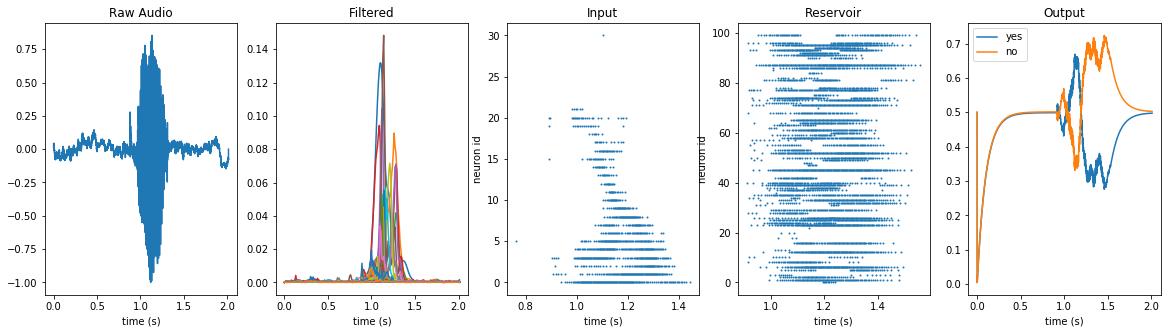

In [63]:
butter.reset_all()
net.reset_all()

# normalize the raw audio
audio /= np.max(np.abs(audio))

# create a timeseries
time_recording = np.arange(0, len(audio) / fs, 1 / fs)
ts_inp = TSContinuous(time_recording, audio)

# apply the Butterworth filter
ts_filt = butter.evolve(ts_inp)

# use the model for prediction
act = net.evolve(ts_filt)


fig = plt.figure(figsize=(20, 5))

ax0 = fig.add_subplot(151)
ax0.set_title("Raw Audio")
ax0.set_xlabel("time (s)")
ts_inp.plot()

ax1 = fig.add_subplot(152)
ax1.set_title("Filtered")
ax1.set_xlabel("time (s)")
ts_filt.plot()

ax2 = fig.add_subplot(153)
ax2.set_title("Input")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("neuron id")
act['input'].plot(s=1)

ax3 = fig.add_subplot(154)
ax3.set_title("Reservoir")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("neuron id")
act['reservoir'].plot(s=1)

ax4 = fig.add_subplot(155)
ax4.set_title("Output")
ax4.set_xlabel("time (s)")
act['output'].plot()
ax4.legend(keywords)



Visually, we see that the model predicted the (in)correct keyword. Using the argmax of the summed activtiy of the readout layer should confirm this.

In [64]:
keywords[np.argmax(np.sum(act['output'].samples, axis=0))]

'no'

## **Fine tuning**

You can play around with the model to improve the performance further.
Important parameters for the reseroir model are:



*   Number of neurons
*   Time constants (different combinations of synaptic and membrane time constants)
*   Recurrent weights (strength, sparsity, structure)
*   Input weights
*   Different keywords




In [22]:
# Tune the model to improve performance